In [8]:
import numpy as np
from sklearn.model_selection import StratifiedKFold
from data_loader import _load, load_challenge, save_challenge
from torch import nn
import torch
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report

In [9]:
class BirdCrossEntropyLoss(nn.Module):
    def __init__(self, device):
        super(BirdCrossEntropyLoss, self).__init__()
        self.rev_matrix = torch.tensor(np.array(
            [[0.05, -0.2, -0.2, -0.2, -0.2, -0.2, -0.2],
             [-0.25,  1., -0.3, -0.1, -0.1, -0.1, -0.1],
                [-0.02, -0.1,  1., -0.1, -0.1, -0.1, -0.1],
                [-0.25, -0.1, -0.3,  1., -0.1, -0.1, -0.1],
                [-0.25, -0.1, -0.3, -0.1,  1., -0.1, -0.1],
                [-0.25, -0.1, -0.3, -0.1, -0.1,  1., -0.1],
                [-0.25, -0.1, -0.3, -0.1, -0.1, -0.1,  1.]])).to(device)
        self.cet = nn.CrossEntropyLoss(reduction='none').to(device)


    def forward(self, input, target):
        ce_loss = self.cet(input, target)

        input_labels = torch.argmax(input, dim=1)
        target_labels = torch.argmax(target, dim=1)
        wanted = self.rev_matrix[target_labels, target_labels]
        actual = self.rev_matrix[target_labels, input_labels]
        cost = wanted - actual
        custom_loss = cost * ce_loss

        return custom_loss.mean()


In [10]:
#X_train, y_train: use for training and validating
#stratify_criterion: used to make sure each fold in cross validation has the same annotator agreement distribution
#X_test, y_test: only use for estimating final performance, prof really emphasized this (weird kink but ok)
X_train, y_train, stratify_criterion, X_test, y_test, a_train, a_test = _load()
print(X_train.shape, y_train.shape, stratify_criterion.shape, X_test.shape, y_test.shape)

(96000, 548) (96000,) (96000,) (24000, 548) (24000,)


In [11]:
def train(dataloader, model, loss_fn, optimizer, show_progress):
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 300 == 0 and show_progress:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

def test(dataloader, model, loss_fn, draw_confusion, y_names, show_progress):
    num_batches = len(dataloader)
    test_loss = 0

    confusion = None
    accuracy = 0
    y_pred_all = np.array([])
    y_all = np.array([])
    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            pred_vec = pred.argmax(1).cpu()
            y_vec = y.argmax(1).cpu()
            y_pred_all = np.concatenate((y_pred_all, pred_vec))
            y_all = np.concatenate((y_all, y_vec))
            accuracy += accuracy_score(y_vec, pred_vec)
            confusion = confusion_matrix(y_vec, pred_vec) if confusion is None else confusion + confusion_matrix(pred_vec, y_vec) 

    test_loss /= num_batches
    accuracy /= num_batches
    if show_progress or draw_confusion:
        print(f"Accuracy: {accuracy:>8f} Avg loss: {test_loss:>8f} \n")
    if draw_confusion:
        print(classification_report(y_all, y_pred_all, target_names=y_names))
        sns.heatmap(confusion, annot=True, cmap='Blues', xticklabels=y_names, yticklabels=y_names, fmt="d")
        plt.ylabel('True label')
        plt.xlabel('Predicted label')
        plt.show(block=False)
    return test_loss

def eval(model_fn, X, y, y_names, criterion, max_epochs, show_progress, X_test, y_test, scaler):
    skf = StratifiedKFold(3)
    device = 'cuda' if torch.cuda.is_available() else 'cpu'

    y_test = np.eye(np.max(y)+1)[y_test] 
    y_test = torch.Tensor(y_test).to(device)

    results = []

    for i, (train_index, validate_index) in enumerate(skf.split(X, criterion)):
        
        print(f"===============================\nFold {i+1}\n===============================")

        X_fold = X[train_index]
        X_fold = scaler.transform(X_fold)
        X_fold = torch.Tensor(X_fold).to(device)

        y_fold = y[train_index]
        y_fold = np.eye(np.max(y)+1)[y_fold]
        y_fold = torch.Tensor(y_fold).to(device)

        X_validate = X[validate_index]
        X_validate = scaler.transform(X_validate)
        X_validate = torch.Tensor(X_validate).to(device)

        y_validate = y[validate_index]
        y_validate = np.eye(np.max(y)+1)[y_validate]
        y_validate = torch.Tensor(y_validate).to(device)

        X_test_scaled = scaler.transform(X_test)
        X_test_scaled = torch.Tensor(X_test_scaled).to(device)

        model = model_fn(None).to(device)

        train_dataloader = DataLoader(TensorDataset(X_fold, y_fold), batch_size=64)
        valid_dataset = TensorDataset(X_validate, y_validate)
        valid_dataloader = DataLoader(valid_dataset, batch_size=len(valid_dataset))
        test_dataset = TensorDataset(X_test_scaled, y_test)
        test_dataloader = DataLoader(test_dataset, batch_size=len(test_dataset))
        optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
        loss_fn = BirdCrossEntropyLoss(device)
        lowest_test_loss = np.infty
        stop_criterion = 0
        for t in range(max_epochs):
            if t % 10 == 0:
                print(f"Epoch {t+1}\n-------------------------------")
            train(train_dataloader, model, loss_fn, optimizer, show_progress)
            test_loss = test(valid_dataloader, model, loss_fn, False, y_names, t % 10 == 0)
            if test_loss > lowest_test_loss:
                stop_criterion += 1
            else:
                lowest_test_loss = test_loss
                stop_criterion = 0
            if stop_criterion >= 10:
                break
        print("Estimated performance:")
        test(test_dataloader, model, loss_fn, True, y_names, False)
        results.append(model)
    return results


In [12]:
scaler = StandardScaler()
scaler.fit(X_train)

model_fn = lambda _: nn.Sequential(
        nn.Linear(548, 256),
        nn.ReLU(),
        nn.Linear(256, 256),
        nn.ReLU(),
        nn.Linear(256, 7)
    )

Fold 1
Epoch 1
-------------------------------
Accuracy: 0.576031 Avg loss: 0.705335 

Epoch 11
-------------------------------
Accuracy: 0.779000 Avg loss: 0.350402 

Epoch 21
-------------------------------
Accuracy: 0.800406 Avg loss: 0.295715 

Epoch 31
-------------------------------
Accuracy: 0.814906 Avg loss: 0.258674 

Epoch 41
-------------------------------
Accuracy: 0.823313 Avg loss: 0.241102 

Epoch 51
-------------------------------
Accuracy: 0.829500 Avg loss: 0.224460 

Epoch 61
-------------------------------
Accuracy: 0.833031 Avg loss: 0.216542 

Epoch 71
-------------------------------
Accuracy: 0.834031 Avg loss: 0.210861 

Epoch 81
-------------------------------
Accuracy: 0.832219 Avg loss: 0.206590 

Epoch 91
-------------------------------
Accuracy: 0.834469 Avg loss: 0.205224 

Epoch 101
-------------------------------
Accuracy: 0.834406 Avg loss: 0.200631 

Epoch 111
-------------------------------
Accuracy: 0.835406 Avg loss: 0.201199 

Epoch 121
----------

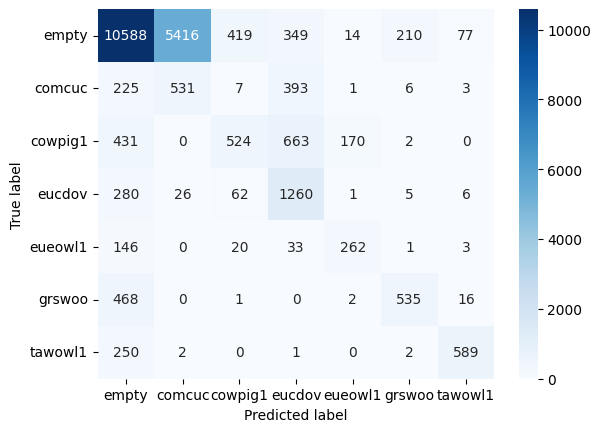

Fold 2
Epoch 1
-------------------------------
Accuracy: 0.627687 Avg loss: 0.659747 

Epoch 11
-------------------------------
Accuracy: 0.790219 Avg loss: 0.321556 

Epoch 21
-------------------------------
Accuracy: 0.812156 Avg loss: 0.271551 

Epoch 31
-------------------------------
Accuracy: 0.824219 Avg loss: 0.243679 

Epoch 41
-------------------------------
Accuracy: 0.828281 Avg loss: 0.230110 

Epoch 51
-------------------------------
Accuracy: 0.831125 Avg loss: 0.220634 

Epoch 61
-------------------------------
Accuracy: 0.831469 Avg loss: 0.213777 

Epoch 71
-------------------------------
Accuracy: 0.834063 Avg loss: 0.210073 

Epoch 81
-------------------------------
Accuracy: 0.835094 Avg loss: 0.206086 

Epoch 91
-------------------------------
Accuracy: 0.837187 Avg loss: 0.203999 

Epoch 101
-------------------------------
Accuracy: 0.838094 Avg loss: 0.200043 

Epoch 111
-------------------------------
Accuracy: 0.840437 Avg loss: 0.195263 

Epoch 121
----------

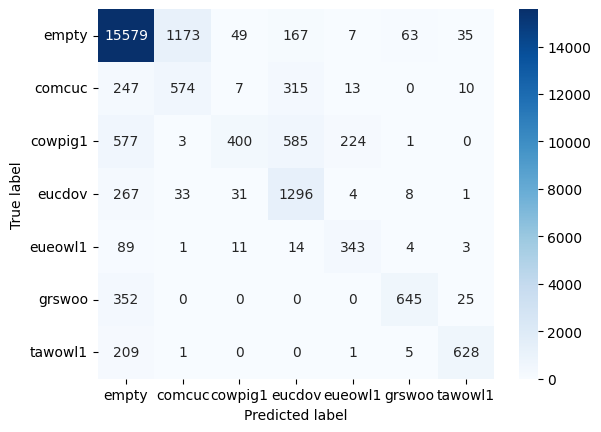

Fold 3
Epoch 1
-------------------------------
Accuracy: 0.287750 Avg loss: 0.776831 

Epoch 11
-------------------------------
Accuracy: 0.610187 Avg loss: 0.383254 

Epoch 21
-------------------------------
Accuracy: 0.680187 Avg loss: 0.320150 

Epoch 31
-------------------------------
Accuracy: 0.695969 Avg loss: 0.299677 

Epoch 41
-------------------------------
Accuracy: 0.709750 Avg loss: 0.287079 

Epoch 51
-------------------------------
Accuracy: 0.730844 Avg loss: 0.273354 

Epoch 61
-------------------------------
Accuracy: 0.744031 Avg loss: 0.263629 

Epoch 71
-------------------------------
Accuracy: 0.762969 Avg loss: 0.255480 

Epoch 81
-------------------------------
Accuracy: 0.771969 Avg loss: 0.248492 

Epoch 91
-------------------------------
Accuracy: 0.782469 Avg loss: 0.243198 

Epoch 101
-------------------------------
Accuracy: 0.792312 Avg loss: 0.237936 

Epoch 111
-------------------------------
Accuracy: 0.799344 Avg loss: 0.233379 

Epoch 121
----------

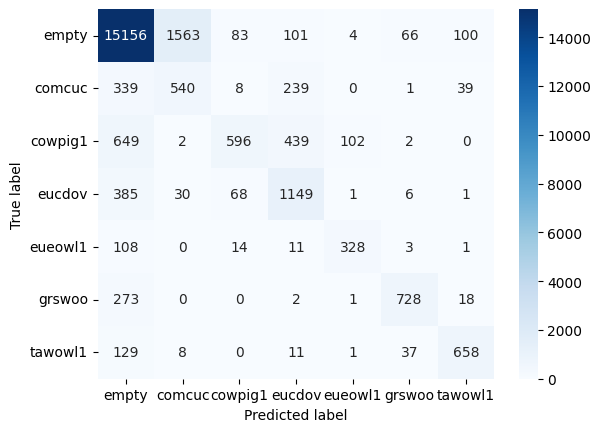

In [13]:
models = eval(model_fn, X_train, y_train, ['empty', 'comcuc', 'cowpig1', 'eucdov', 'eueowl1', 'grswoo', 'tawowl1'], stratify_criterion, 500, False, X_test, y_test, scaler)

In [14]:
torch.save(models[0].state_dict(), 'nn')

In [15]:
challenge = load_challenge()
print(challenge.shape)

(16, 3000, 548)


In [16]:
model = model_fn(None)
model.load_state_dict(torch.load('nn'))
model.eval()

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = model.to(device)
results = torch.Tensor(np.empty((challenge.shape[0], challenge.shape[1]))).to(device)
for i in range(challenge.shape[0]):
    challenge_subset = challenge[i]
    challenge_subset = scaler.transform(challenge_subset)
    challenge_subset = torch.Tensor(challenge_subset).to(device)
    preds = model(challenge_subset)
    pred_labels = torch.argmax(preds, dim=1)
    results[i, :] = pred_labels
results = results.int().cpu().numpy()
print(results, results.shape)
save_challenge('nn_test', results)
   

[[0 0 0 ... 0 0 3]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 3 3 3]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 6 0 0]
 [0 0 0 ... 0 0 0]] (16, 3000)
